In [1]:
import numpy as np

-------

В работе + стоят напротив тех классов, что смогли пройти тесты (по итогу все). Некоторые тесты я подправляла - где-то надо было изменить паддинг, где-то 1 раз тип данных. Перемещаться по работе удобно по меню с заголовкам - все этапы я помечала небольшими заголовками.

-----------------

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [2]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        # хранит выходные данные после forward()
        self.output = None
        # хранит градиенты после backward()
        self.gradInput = None
        # показывает режим модели
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container +


**Define** a forward and backward pass procedures.

In [3]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        # Your code goes here. ################################################

        self.output = input
        for module in self.modules:
            self.output = module.forward(self.output)
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        intermediate_outputs = [input]  
        
        for module in self.modules[:-1]:
            intermediate_outputs.append(module.forward(intermediate_outputs[-1]))
        
        # сделаем все как в примечании выше
        current_grad = gradOutput
        for i in range(len(self.modules)-1, 0, -1):
            current_grad = self.modules[i].backward(intermediate_outputs[i], current_grad)

        self.gradInput = self.modules[0].backward(input, current_grad)
        return self.gradInput

    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer+
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [4]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # self.output = ...
        # просто реализуем wx+b и np.dot - скалярное пр
        self.output = np.dot(input, self.W.T) + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        # self.gradInput = ...
        self.gradInput = np.dot(gradOutput, self.W)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        # self.gradW = ... ; self.gradb = ...
        self.gradW =  self.gradW + np.dot(gradOutput.T, input)
        self.gradb = self.gradb + np.sum(gradOutput, axis=0)
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax +
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

https://mmuratarat.github.io/2019-01-27/derivation-of-softmax-function
почитать тут

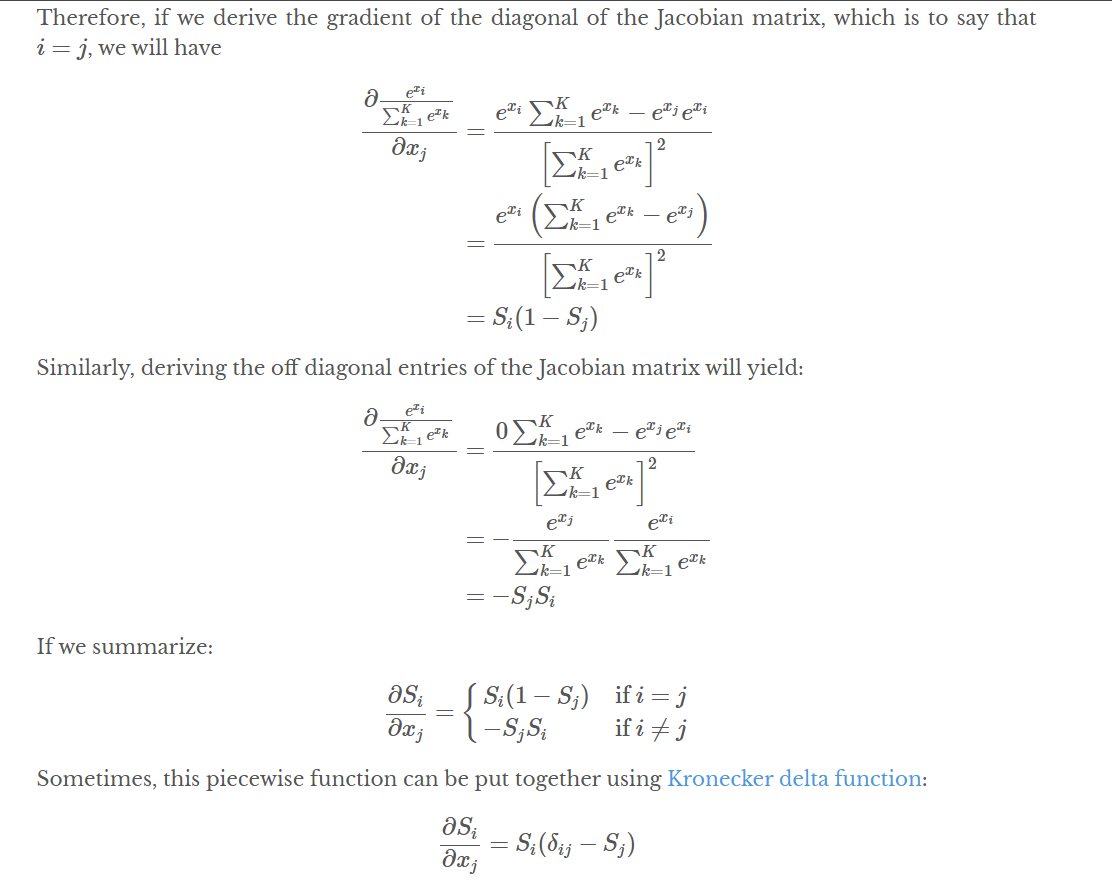

In [5]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        # не забываем, что в знаменателе j а не i
        self.output = np.exp(input)/np.sum(np.exp(input), axis=1, keepdims=True)
        
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.zeros_like(input)
        for i in range(len(self.output)):
#  в статье S это столбец софтмаксов (ешек)
            s = self.output[i].reshape(-1, 1)
# np.diagflat - входные элементы по диагонали. s, s.T - это произведение Si*Sj из статьи. т.е. по диагонали (если i=j) формула будет Si(1−Sj) = Si-Si*Sj 
# а помимо диагонали все числа =0. т.е. формула будет Si(0−Sj)= -Si*Sj
# jacobian - наша итоговая частная производная
            jacobian = np.diagflat(s) - np.dot(s, s.T)
            self.gradInput[i] = np.dot(jacobian, gradOutput[i])


        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax +
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [6]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        # там под суммой j, надо осторожно!
        
        self.output = (self.output) - np.log(np.sum(np.exp(self.output), axis=1, keepdims=True))
        
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################

        self.gradInput = gradOutput - np.exp(self.output) * np.sum(gradOutput, axis=1, keepdims=True)
        
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization +
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [7]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None
        self.normalized_input = None


    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please

        if self.training== True:
            self.batch_mean = np.mean(input, axis=0)
            self.batch_var = np.var(input, axis=0)
# далее делаем все по формулам выше
            if self.moving_mean is None:
                self.moving_mean = self.batch_mean
                self.moving_variance = self.batch_var
            else:

                self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * self.batch_mean
                self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * self.batch_var

            self.output = (input - self.batch_mean) / np.sqrt(self.batch_var + self.EPS)
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output


    def updateGradInput(self, input, gradOutput):

        if self.training == False:
            self.gradInput = gradOutput / np.sqrt(self.moving_variance + self.EPS)
            return self.gradInput

        self.gradInput = (gradOutput / np.sqrt(self.batch_var + self.EPS)) + (np.sum(gradOutput * (input - self.batch_mean) * -0.5 * (self.batch_var + self.EPS)**(-1.5), axis=0) * 2 * (input - self.batch_mean) / input.shape[0]) + (np.sum(gradOutput * -1 / np.sqrt(self.batch_var + self.EPS), axis=0) + d_var * np.mean(-2 * (input - self.batch_mean), axis=0) / input.shape[0])

        return self.gradInput
    def __repr__(self):
        return "BatchNormalization"

In [8]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout +
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [9]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training == True:
            # если рандомная вер-ть меньше заданной p то тру
            self.mask= (np.random.random_sample(input.shape) > self.p) / (1- self.p)
            self.output = input*self.mask
        else:
            self.output = input
        
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training == True:
            # градиент - коэфф
            self.gradInput=self.mask* gradOutput 
        else:
            self.gradInput =gradOutput
        
        return self.gradInput

    def __repr__(self):
        return "Dropout"

# 6. (2.0) Conv2d +
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [44]:
# тихий ужас
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding
        self.use_bias = bias
        self.padding_mode = padding_mode
        self.training = True

        self.weight = np.random.randn(out_channels, in_channels, *self.kernel_size).astype(np.float32)
        self.bias = np.random.randn(out_channels).astype(np.float32) if bias else None
        self.grad_weight = np.zeros_like(self.weight, dtype=np.float32)
        if self.use_bias:
            self.grad_bias = np.zeros_like(self.bias, dtype=np.float32)

    def train(self):
        self.training = True

    def evaluate(self):
        self.training = False


    def _get_padding(self, input_shape):
        if isinstance(self.padding, str) and self.padding == 'same':
            pad_height = max((int(np.ceil(input_shape[2] / self.stride[0])) - 1) * self.stride[0] + self.kernel_size[0] - input_shape[2], 0)
            pad_width  = max((int(np.ceil( input_shape[3] / self.stride[1])) - 1) * self.stride[1] + self.kernel_size[1] -  input_shape[3], 0)

            pad_top = pad_height // 2
            pad_bottom = pad_height - pad_height // 2
            pad_left = pad_width  // 2
            pad_right = pad_width - pad_width // 2

            return (pad_top, pad_bottom, pad_left, pad_right)
        elif isinstance(self.padding, int):
            return (self.padding, self.padding, self.padding, self.padding)
        elif isinstance(self.padding, tuple):
            if len(self.padding) == 2:
                return (self.padding[0], self.padding[0], self.padding[1], self.padding[1])
            elif len(self.padding) == 4:
                return self.padding
        raise ValueError("Invalid padding format")

    def pad_full(self, input, padding):
        pad_top, pad_bottom, pad_left, pad_right = padding

        if self.padding_mode == 'zeros':
            mode = 'constant'
            kwargs = {'constant_values': 0}
        elif self.padding_mode == 'replicate':
            mode = 'edge'
            kwargs = {}
        elif self.padding_mode == 'reflect':
            mode = 'reflect'
            kwargs = {}

        pad_width = [
            (0, 0),  # batch
            (0, 0),  # channels
            (pad_top, pad_bottom),
            (pad_left, pad_right)
        ]

        return np.pad(input, pad_width=pad_width, mode=mode, **kwargs)

    def updateOutput(self, input):
        self.input = input
        self.padding_vals = self._get_padding(input.shape)
        input_padded = self.pad_full(input, self.padding_vals)
        self.input_padded = input_padded
        
        output = np.zeros((input_padded.shape[0], self.out_channels, (input_padded.shape[2] - self.kernel_size[0]) // self.stride[0] + 1, (input_padded.shape[3] - self.kernel_size[1]) // self.stride[1] + 1), dtype=np.float32)

        for b in range(input_padded.shape[0]):
            for oc in range(self.out_channels):
                for i in range((input_padded.shape[2] - self.kernel_size[0]) // self.stride[0] + 1):
                    for j in range((input_padded.shape[3] - self.kernel_size[1]) // self.stride[1] + 1):
                        h_start = i * self.stride[0]
                        w_start = j * self.stride[1]
                        region = input_padded[b, :, h_start:h_start+self.kernel_size[0], w_start:w_start+self.kernel_size[1]]
                        output[b, oc, i, j] = np.sum(region * self.weight[oc])
                        if self.use_bias:
                            output[b, oc, i, j] += self.bias[oc]

        self.output = output
        return output

    def updateGradInput(self, input, gradOutput):
        pad_top, pad_bottom, pad_left, pad_right = self.padding_vals
        grad_input_padded = np.zeros_like(self.input_padded, dtype=np.float32)

        for b in range(input.shape[0]):
            for oc in range(self.out_channels):
                for i in range(gradOutput.shape[2]):
                    for j in range(gradOutput.shape[3]):
                        h_start = i * self.stride[0]
                        w_start = j * self.stride[1]
                        grad = gradOutput[b, oc, i, j]
                        grad_input_padded[b, :, h_start:h_start+self.kernel_size[0], w_start:w_start+self.kernel_size[1]] += self.weight[oc] * grad

        self.gradInput = grad_input_padded[:, :, pad_top:input.shape[2]+pad_top, pad_left:input.shape[3]+pad_left]
        return self.gradInput

    def getParameters(self):
        return [self.weight, self.bias] if self.use_bias else [self.weight]

    def getGradParameters(self):
        return [self.grad_weight, self.grad_bias] if self.use_bias else [self.grad_weight]

    def zeroGradParameters(self):
        self.grad_weight.fill(0)
        if self.use_bias:
            self.grad_bias.fill(0)

    def accGradParameters(self, input, gradOutput):


        self.grad_weight.fill(0)
        if self.use_bias:
            self.grad_bias.fill(0)

        for b in range(gradOutput.shape[0]):
            for oc in range(self.out_channels):
                for i in range(gradOutput.shape[2]):
                    for j in range(gradOutput.shape[3]):
                        h_start = i * self.stride[0]
                        w_start = j * self.stride[1]
                        region = self.input_padded[b, :, h_start:h_start+self.kernel_size[0], w_start:w_start+self.kernel_size[1]]
                        self.grad_weight[oc] += region * gradOutput[b, oc, i, j]
                        if self.use_bias:
                            self.grad_bias[oc] += gradOutput[b, oc, i, j]

    def __repr__(self):
        return "Conv2d"

# 7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**] +
(https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [11]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        self.input = input
        N, C, H, W = input.shape
        # здесь задача - просто найти максимумы в окнах и их позиции
        k, s, p = self.kernel_size, self.stride, self.padding
        input_padded = np.pad(input, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant', constant_values=-np.inf)
        windows = sliding_window_view(input_padded, (k, k), axis=(-2, -1))[:, :, ::s, ::s]
        self.output = np.max(windows, axis=(-2, -1), keepdims=False)
        self.max_indices = np.argmax(windows.reshape(N, C, *self.output.shape[2:], -1), axis=-1)

        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C, H, W = input.shape
        k, s, p = self.kernel_size, self.stride, self.padding
        grad_input_padded = np.zeros((N, C, H + 2 * p, W + 2 * p))
        H_out, W_out = self.output.shape[2:]
        max_positions = np.unravel_index(self.max_indices, (k, k))

        for i in range(H_out):
            for j in range(W_out):
                h_start, w_start = i * s, j * s
                h_indices, w_indices = max_positions[0][:, :, i, j], max_positions[1][:, :, i, j]
                grad_input_padded[np.arange(N)[:, None], np.arange(C), h_start + h_indices, w_start + w_indices] += gradOutput[:, :, i, j]

        self.gradInput = grad_input_padded[:, :, p:H + p, p:W + p] if p > 0 else grad_input_padded
        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"


class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        self.input = input
        N, C, H, W = input.shape
        k, s, p = self.kernel_size, self.stride, self.padding

        # тут добавим паддинг
        input_padded = np.pad(input, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant', constant_values=0)
        windows = sliding_window_view(input_padded, (k, k), axis=(-2, -1))[:, :, ::s, ::s] #слайдинг виндоу вроде разрешили использовать
        self.output = np.mean(windows, axis=(-2, -1))

        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C, H, W = input.shape
        k, s, p = self.kernel_size, self.stride, self.padding
        # тожк добавим паддинг
        grad_input_padded = np.zeros((N, C, H + 2 * p, W + 2 * p))
        H_out, W_out = self.output.shape[2:]
        # grad_expanded - расширенный градиент
        grad_expanded = gradOutput[:, :, :, :, None, None] / (k * k)
        for i in range(H_out):
            for j in range(W_out):
                h_start, w_start = i * s, j * s
                grad_input_padded[:, :, h_start:h_start + k, w_start:w_start + k] += grad_expanded[:, :, i, j]

        self.gradInput = grad_input_padded[:, :, p:H + p, p:W + p] if p > 0 else grad_input_padded
        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

# 8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. + +
They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [12]:
class GlobalMaxPool2d(Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()
        self.input_shape = None
        self.max_mask = None # маска для backward

    def updateOutput(self, input):
        self.input_shape = input.shape
        N, C, H, W = self.input_shape

        # в скобках записаны те места, в которых были максимумы по всем измерениям
        self.max_mask = (input == np.max(input, axis=(2, 3), keepdims=True))
        # Убираем лишние оси
        self.output = self.output.reshape(N, C)
        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C = gradOutput.shape
        H, W = self.input_shape[2:]
        gradOutput_expanded = gradOutput.reshape(N, C, 1, 1)
        num_max = np.sum(self.max_mask, axis=(2, 3), keepdims=True) # также надо будет не забыть про деление на 0 
        num_max[num_max == 0] = 1 
        self.gradInput = (self.max_mask * gradOutput_expanded) / num_max
        return self.gradInput

    def __repr__(self):
        return "GlobalMaxPool2d"
    def __repr__(self):
        return "GlobalMaxPool2d"

class GlobalAvgPool2d(Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def updateOutput(self, input):
        # просто считаем среднее во всех каналах
        self.output = np.mean(input, axis=(2, 3), keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput / (input.shape[2] * input.shape[3])
        return self.gradInput

    def __repr__(self):
        return "GlobalAvgPool2d"


# 9. (0.2) Implement [**Flatten**] +
(https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [13]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        # Your code goes here. ################################################
        input_shape = input.shape
        if self.end_dim == -1:
            self.end_dim = len(input_shape) - 1
        flatten_shape = input_shape[:self.start_dim] + (-1,) + input_shape[self.end_dim + 1:]
        
        # превращаем в сосиску
        self.output = input.reshape(flatten_shape)        
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        input_shape = input.shape
        grad_input_shape = list(input_shape[:self.start_dim]) + [-1] + list(input_shape[self.end_dim + 1:])
        self.gradInput = gradOutput.reshape(input.shape)         
        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [14]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # тут типа если х больше 0, то производная =1 (тру)
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU +
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

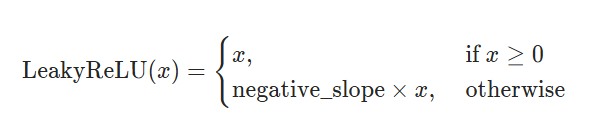

In [15]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # если больше 0 то просто х, если меньше, то слоуп* х
        self.output= np.where(input>0, input, self.slope*input)
        return  self.output

    def updateGradInput(self, input, gradOutput):

        # Your code goes here. ################################################
        # там где инпут больше 0 умножаем gradOutput на 1 (проивзодная), если инпут меньше 0, то умножаем на слоуп (он будет производной)
        self.gradInput = np.multiply(gradOutput , np.where(input>0, 1, self.slope))
        
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU +
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

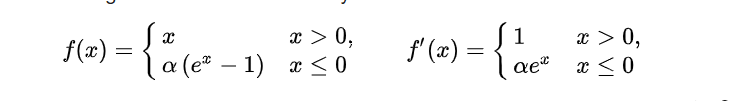

In [16]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
         # Your code goes here. ################################################
        self.output= np.where(input>0, input, self.alpha*(np.exp(input)-1))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        # тут производной будет либо 1 (когда больше 0) либо альфа*е(х)
        self.gradInput = np.multiply(gradOutput , np.where(input>0, 1, self.alpha*np.exp(input)))
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus +
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

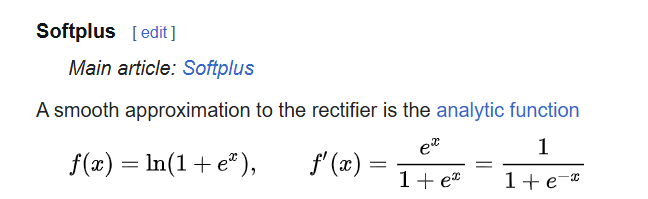

In [17]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output= np.log(1+np.exp(input))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        # возьмем произодную со скрина с википедии)
        self.gradInput = np.multiply(gradOutput , (1/(1+np.exp(-1*input))) )
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

# 13. (0.2) Gelu +
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [18]:
 from scipy.stats import norm

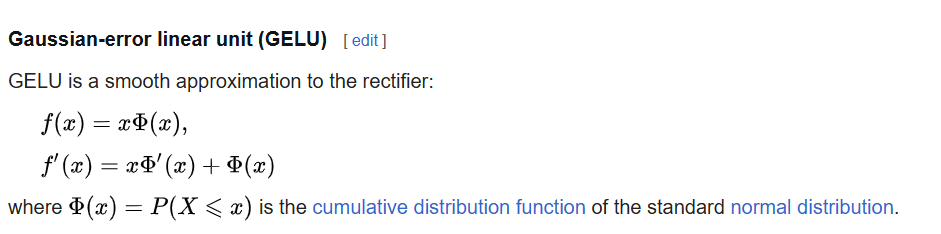

Для производной нашла в интернете какой-то тихий ужас:
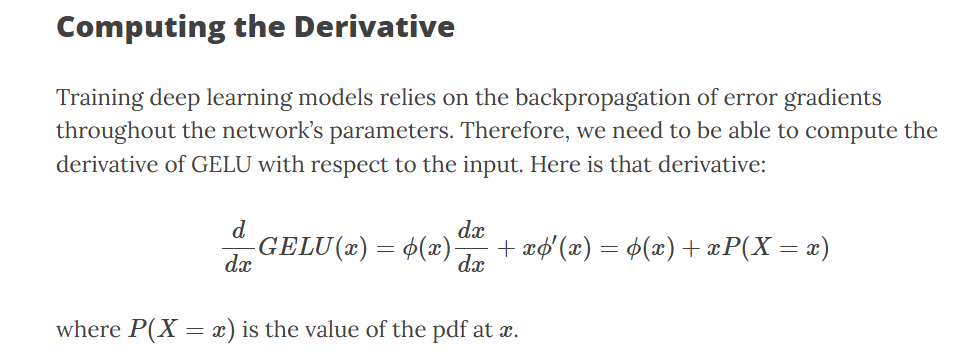

In [19]:
class Gelu(Module):
    def __init__(self):
        # тут была ошибка в супер() , заменила на джелу
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # нашла на стаковерфлоу функцию norm cdf - вычисляет CDF нормального распределения
        self.output= input* norm.cdf(input)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        # берем производную со скрина + юзаем norm.pdf
        self.gradInput = gradOutput *(norm.cdf(input) + input*norm.pdf(input))
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [20]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [21]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable) +
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



чекнула сайт, взяла оттуда это:

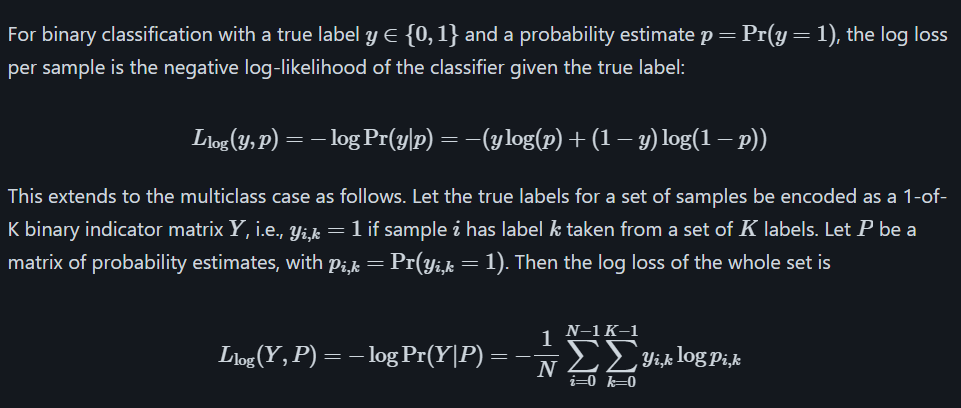

In [22]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15

    def __init__(self):

        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):

        input_clamp = np.clip(input, self.EPS, 1.0 - self.EPS)
        self.output = -np.sum(target * np.log(input_clamp)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        input_clamp = np.clip(input, self.EPS, 1.0 - self.EPS)
        self.gradInput = -(target / input_clamp) / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable) +
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [158]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################

        self.output = -np.sum(np.sum(target * input, axis=1))/ input.shape[0]        
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        self.gradInput = -target / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

------------------------

# ЧАСТЬ 2

In [24]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

В качестве метрики взяла R^2, в качестве лосса - MSE. Нарисованы графики как для трейна, так и для валидации. После тренировочных эпох в каждой модели посчитаны лосс+метрика на тестовой части датасета. Сделала простой шедулер для шага обучения, ранняя остановка тоже есть. 


---------------------

## Сгенерим данные

In [25]:
np.random.seed(42)
num_samples = 1000
input_dim = 10
output_dim = 3

X = np.random.randn(num_samples, input_dim) * 2 + 1
true_weights = np.random.randn(input_dim, output_dim)
true_bias = np.random.randn(output_dim)
y = X @ true_weights + true_bias + np.random.randn(num_samples, output_dim) * 0.5

train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

scaler = StandardScaler()

# и заскалируем их
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Оптимизатор и шедулер

In [26]:
# оптимизатор в виде стохастического градиентного спуска
class SGD:
    def __init__(self, modules, lr=0.01, momentum=0.9):
        self.modules = modules
        self.lr = lr
        self.momentum = momentum
    
    def step(self):
        for module in self.modules:
            params = module.getParameters()
            grads = module.getGradParameters()
            if params and grads:
                if not hasattr(module, 'velocity'):
                    module.velocity = [np.zeros_like(p) for p in params]
                
                for i, (param, grad) in enumerate(zip(params, grads)):
                    if grad is not None:
                        module.velocity[i] = self.momentum * module.velocity[i] + (1 - self.momentum) * grad
                        param -= self.lr * module.velocity[i]
    
    def zero_grad(self):
        for module in self.modules:
            module.zeroGradParameters()

In [27]:
# шедулер - просто сигнал для шага размером в step_size
class StepLR: 
    def __init__(self, optimizer, step_size, gamma=0.1):
        self.optimizer = optimizer
        self.step_size = step_size
        self.gamma = gamma
        self.last_step = 0
    
    def step(self):
        self.last_step += 1
        if self.last_step % self.step_size == 0:
            self.optimizer.lr *= self.gamma

## Ранняя остановка, FCNN, R^2

In [28]:
class FCNN(Sequential):
    def __init__(self, layers):
        super(FCNN, self).__init__()

        # собираем наше лего
        for layer in layers:
            self.add(layer)
    
    def forward(self, input):
        return super().forward(input)
    
    def backward(self, input, gradOutput):
        return super().backward(input, gradOutput)

In [29]:
class EarlyStopping:
    def __init__(self, patience=100, min_delta=0.0001):
        # параметры выше можно менять, но я решила так оставить
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [30]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true, axis=0))**2)
    return 1 - (ss_res / ss_tot)

## Обучение модельки

In [36]:
def train_and_evaluate(model, criterion, optimizer, scheduler, X_train, y_train, X_val, y_val, X_test, y_test, num_epochs, batch_size):
    train_losses = []
    val_losses = []
    train_r2_scores = []
    val_r2_scores = []
    best_val_loss = np.inf
    best_model_state = None
    
    for epoch in range(num_epochs):
        # режим тренировки модели
        model.train()
        epoch_loss = 0
        permutation = np.random.permutation(len(X_train))
        
        for i in range(0, len(X_train), batch_size):
            batch_indices = permutation[i:i+batch_size]
            batch_X = X_train[batch_indices]
            batch_y = y_train[batch_indices]

            output = model.forward(batch_X)
            loss = criterion.forward(output, batch_y)
            epoch_loss += loss * len(batch_X)
 
            gradOutput = criterion.backward(output, batch_y)
            model.backward(batch_X, gradOutput)
            optimizer.step()
            optimizer.zero_grad()
        
        train_loss = epoch_loss / len(X_train)
        train_losses.append(train_loss)
        
        # считаем р2
        train_r2 = r2_score(y_train, model.forward(X_train))
        train_r2_scores.append(train_r2)
        
        # переводим модельку в режим валидации
        model.evaluate()
        val_output = model.forward(X_val)
        val_loss = criterion.forward(val_output, y_val)
        val_losses.append(val_loss)
        

        val_r2 = r2_score(y_val, val_output)
        val_r2_scores.append(val_r2)
        
        # добавила раннюю остановку
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break
        
        scheduler.step()
        
        if epoch % 10 == 0:
            print('-'*40)
            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train R² = {train_r2:.4f}, "
                  f"Val Loss = {val_loss:.4f}, Val R² = {val_r2:.4f}")
            
    return train_losses, val_losses, train_r2_scores, val_r2_scores

## Отрисовка графиков

In [37]:
def plot_metrics(train_losses, val_losses, train_r2_scores, val_r2_scores, y_test, test_output, output_size):
    plt.figure(figsize=(12, 10))

    # график для лоссов
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # не забываем считать р2
    plt.subplot(2, 2, 2)
    plt.plot(train_r2_scores, label='Train R²')
    plt.plot(val_r2_scores, label='Val R²')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.legend()
    plt.title('Training and Validation R²')

    # и красивый график предсказанных/истинных значений
    plt.subplot(2, 2, 3)
    for i in range(output_size):
        plt.scatter(y_test[:, i], test_output[:, i], alpha=0.5, label=f'Target {i+1}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.title('Predictions vs True Values')

    plt.tight_layout()
    plt.show()


-----------------------------

# Модель 1 (маленькая)

напишем самую простую модельку - 64 нейрона в первом слое, функция активации - релу. в качестве оптимизатора везде будет использоваться sgd

----------------------------------------
Epoch 0: Train Loss = 119.7780, Train R² = -0.0965, Val Loss = 121.9800, Val R² = -0.1711
----------------------------------------
Epoch 10: Train Loss = 38.6614, Train R² = 0.6728, Val Loss = 34.0773, Val R² = 0.6728
----------------------------------------
Epoch 20: Train Loss = 3.0257, Train R² = 0.9744, Val Loss = 2.8658, Val R² = 0.9725
----------------------------------------
Epoch 30: Train Loss = 1.7012, Train R² = 0.9846, Val Loss = 1.7917, Val R² = 0.9828
----------------------------------------
Epoch 40: Train Loss = 1.4044, Train R² = 0.9872, Val Loss = 1.5820, Val R² = 0.9848
----------------------------------------
Epoch 50: Train Loss = 1.2480, Train R² = 0.9885, Val Loss = 1.4695, Val R² = 0.9859
----------------------------------------
Epoch 60: Train Loss = 1.1941, Train R² = 0.9890, Val Loss = 1.4216, Val R² = 0.9864
----------------------------------------
Epoch 70: Train Loss = 1.1484, Train R² = 0.9894, Val Loss = 1.3942, V

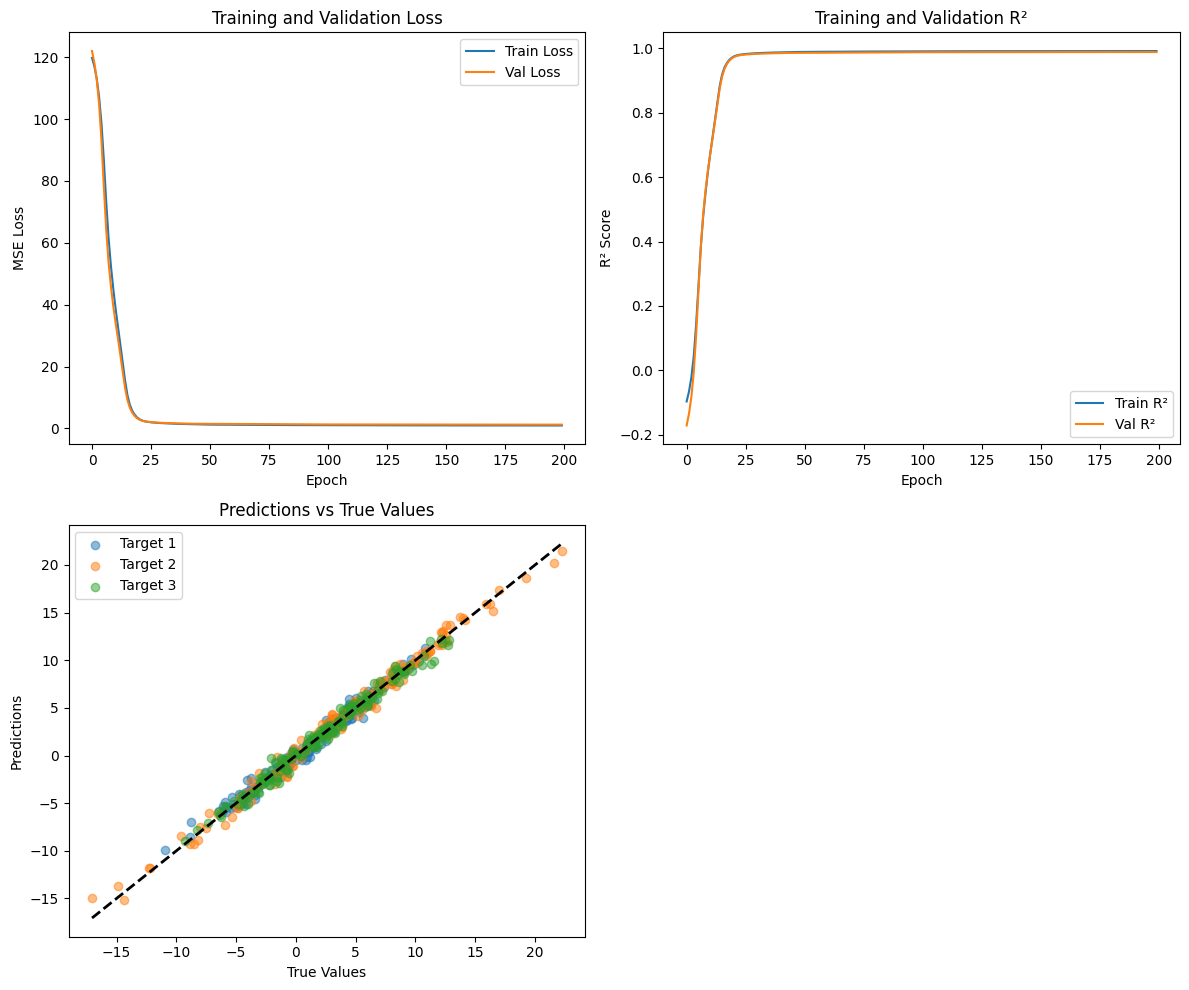

In [38]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]


layers = [
    Linear(input_size, 64),    
    ReLU(),                                  
    Linear(64, 32),               
    ReLU(),                     
    Linear(32, output_size)    
]

model = FCNN(layers)
criterion = MSECriterion()
optimizer = SGD(model.modules, lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
early_stopping = EarlyStopping()
batch_size = 32
num_epochs = 200

# Запустим обучение
train_losses, val_losses, train_r2_scores, val_r2_scores = train_and_evaluate(model, 
            criterion, optimizer, scheduler, X_train, y_train, X_val, y_val, X_test, y_test, num_epochs, batch_size)


# тестим модель - необходимо перенести ее в состояние евалюейт 
model.evaluate()

test_output = model.forward(X_test)
test_loss = criterion.forward(test_output, y_test)
test_r2 = r2_score(y_test, test_output)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"\nTest R^2: {test_r2:.4f}")

plot_metrics(train_losses, val_losses, train_r2_scores, val_r2_scores, y_test, test_output, output_size)

# Модель 2 (средняя)

возьмем 500 эпох, начальный слой в 128 нейронов, добавим дропаут и батчнорм  + тут сработал early stopping 

----------------------------------------
Epoch 0: Train Loss = 124.0845, Train R² = -0.1172, Val Loss = 124.3191, Val R² = -0.1935
----------------------------------------
Epoch 10: Train Loss = 17.2754, Train R² = 0.8787, Val Loss = 9.3058, Val R² = 0.9107
----------------------------------------
Epoch 20: Train Loss = 10.4694, Train R² = 0.9372, Val Loss = 2.1533, Val R² = 0.9793
----------------------------------------
Epoch 30: Train Loss = 10.1037, Train R² = 0.9406, Val Loss = 1.8372, Val R² = 0.9824
----------------------------------------
Epoch 40: Train Loss = 10.2367, Train R² = 0.9410, Val Loss = 1.9690, Val R² = 0.9811
----------------------------------------
Epoch 50: Train Loss = 11.1257, Train R² = 0.9409, Val Loss = 1.7124, Val R² = 0.9836
----------------------------------------
Epoch 60: Train Loss = 11.7501, Train R² = 0.9428, Val Loss = 1.7281, Val R² = 0.9834
----------------------------------------
Epoch 70: Train Loss = 9.8906, Train R² = 0.9401, Val Loss = 1.666

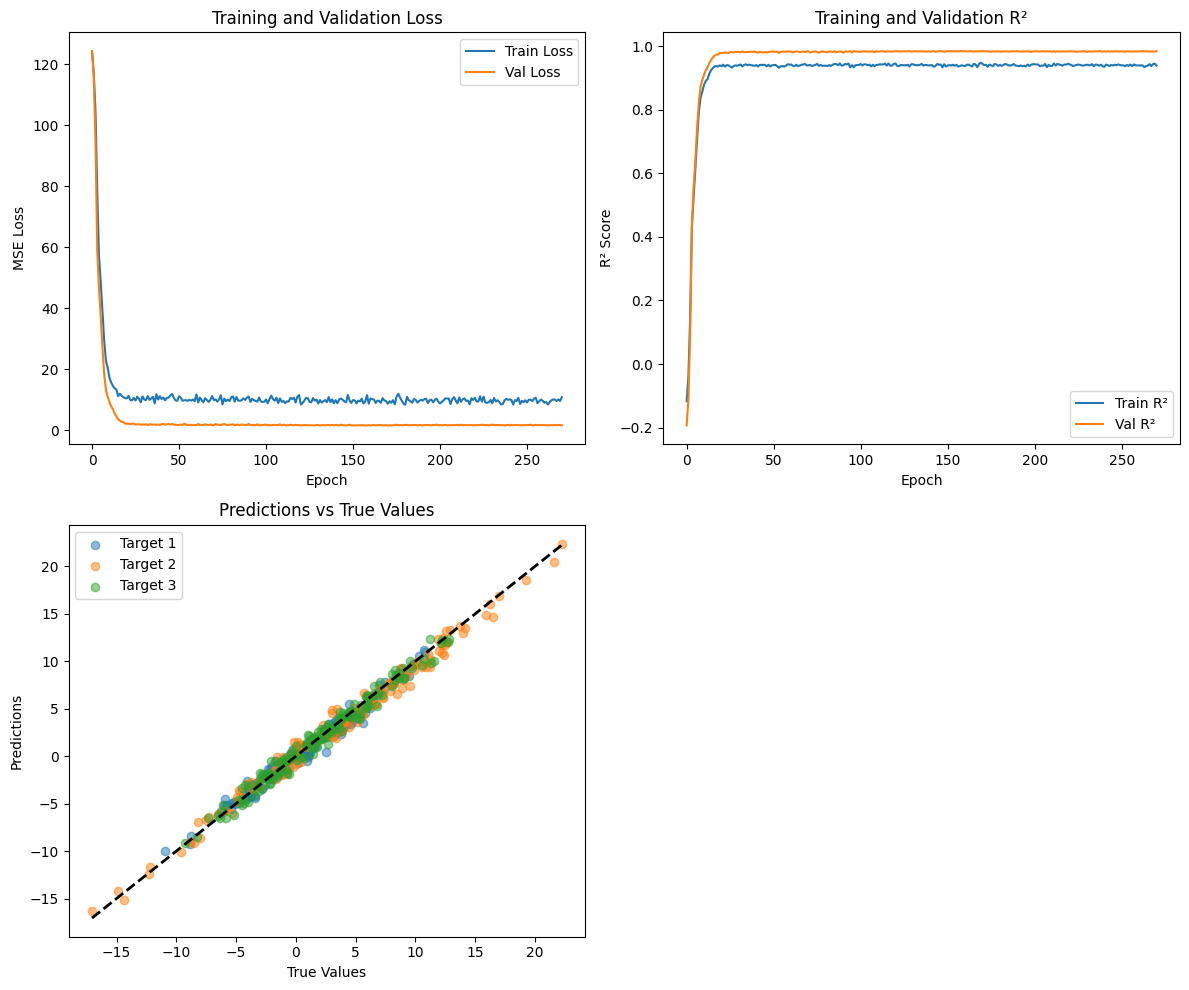

In [39]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

layers = [
    Linear(input_size, 128),      
    ReLU(),                      
    Dropout(0.2),              
    Linear(128, 64),            
    BatchNormalization(),       
    ReLU(),                     
    Linear(64, 32),      
    ReLU(),
    Linear(32, output_size)
]

# выберем еще некоторые параметры для модельки
model2 = FCNN(layers)
criterion = MSECriterion()
optimizer = SGD(model2.modules, lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
early_stopping = EarlyStopping()
batch_size = 32
num_epochs = 500


train_losses, val_losses, train_r2_scores, val_r2_scores = train_and_evaluate(model2, 
            criterion, optimizer, scheduler, X_train, y_train, X_val, y_val, X_test, y_test, num_epochs, batch_size)


# тестим модель - необходимо перенести ее в состояние евалюейт 
model2.evaluate()

test_output = model2.forward(X_test)
test_loss = criterion.forward(test_output, y_test)
test_r2 = r2_score(y_test, test_output)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"\nTest R^2: {test_r2:.4f}")

plot_metrics(train_losses, val_losses, train_r2_scores, val_r2_scores, y_test, test_output, output_size)

# Модель 3

возьмем 1000 эпох, 256 нейронов в начальном слое, добавим Gelu, второй Dropout, размер батча увеличим до 64.  + тут сработал early stopping 

----------------------------------------
Epoch 0: Train Loss = 122.9641, Train R² = -0.1352, Val Loss = 126.3144, Val R² = -0.2127
----------------------------------------
Epoch 10: Train Loss = 100.1855, Train R² = 0.1419, Val Loss = 94.2560, Val R² = 0.0951
----------------------------------------
Epoch 20: Train Loss = 50.0602, Train R² = 0.5726, Val Loss = 40.6030, Val R² = 0.6102
----------------------------------------
Epoch 30: Train Loss = 17.4735, Train R² = 0.8509, Val Loss = 7.8808, Val R² = 0.9243
----------------------------------------
Epoch 40: Train Loss = 12.3771, Train R² = 0.8940, Val Loss = 2.3017, Val R² = 0.9779
----------------------------------------
Epoch 50: Train Loss = 14.7289, Train R² = 0.8957, Val Loss = 1.7626, Val R² = 0.9831
----------------------------------------
Epoch 60: Train Loss = 13.4742, Train R² = 0.9042, Val Loss = 1.6359, Val R² = 0.9843
----------------------------------------
Epoch 70: Train Loss = 11.2097, Train R² = 0.9075, Val Loss = 1

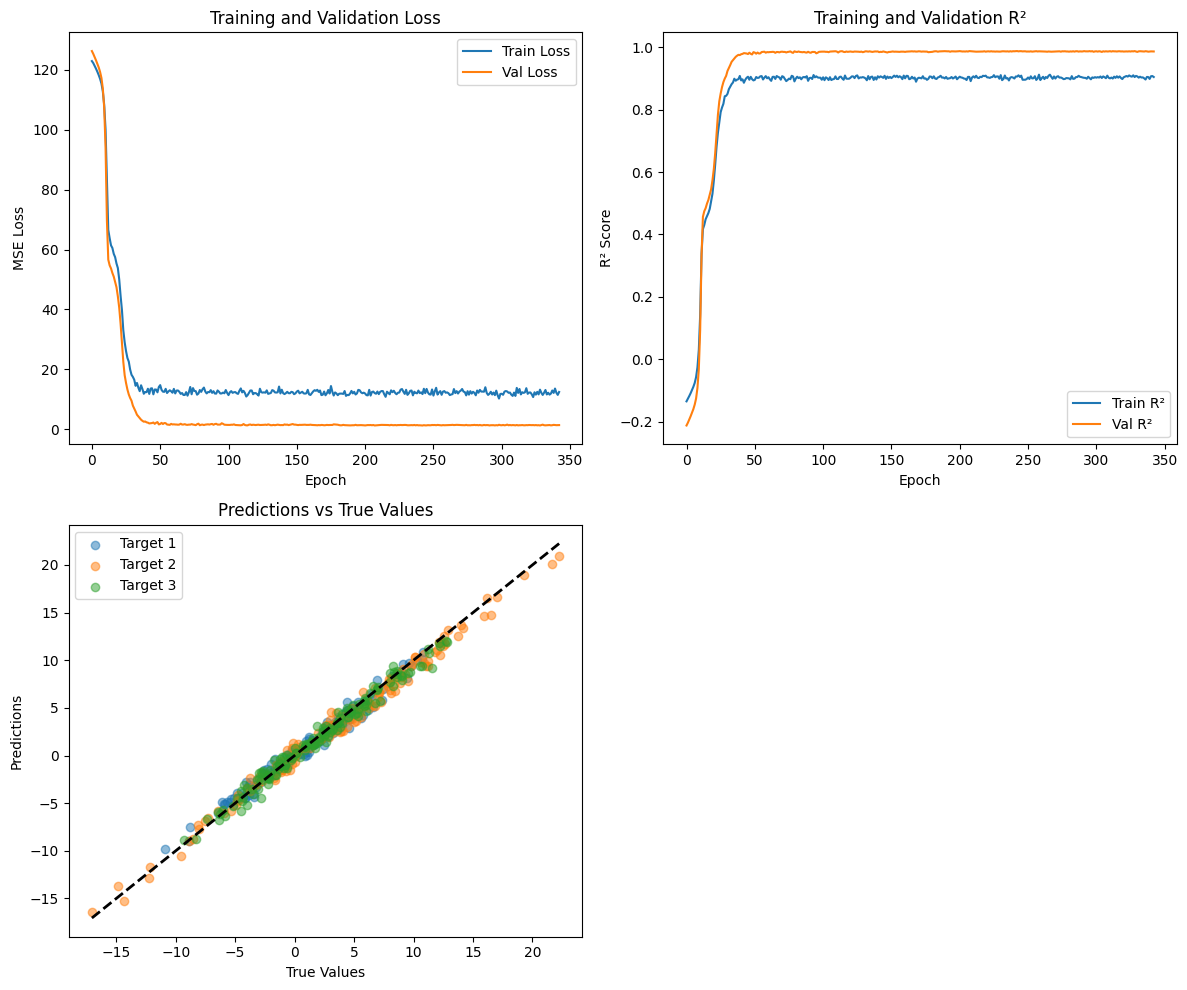

In [40]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]


# Определим слои
layers = [
    Linear(input_size, 256),      # Первый линейный слой
    Gelu(),                      # Функция активации ReLU
    Dropout(0.2),                # Dropout
    Linear(256, 128),              # Второй линейный слой
    BatchNormalization(),        # BatchNormalization
    Gelu(),                      # Еще одна функция активации ReLU
    Linear(128, 64),      # Финальный линейный слой
    Gelu(),
    Dropout(0.2),   
    Linear(64, 32),
    Gelu(),
    Linear(32, output_size)
]

# выберем еще некоторые параметры для модельки
model2 = FCNN(layers)
criterion = MSECriterion()
optimizer = SGD(model2.modules, lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
early_stopping = EarlyStopping()
batch_size = 64
num_epochs = 1000


train_losses, val_losses, train_r2_scores, val_r2_scores = train_and_evaluate(model2, 
            criterion, optimizer, scheduler, X_train, y_train, X_val, y_val, X_test, y_test, num_epochs, batch_size)


# тестим модель - необходимо перенести ее в состояние евалюейт 
model2.evaluate()

test_output = model2.forward(X_test)
test_loss = criterion.forward(test_output, y_test)
test_r2 = r2_score(y_test, test_output)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"\nTest R^2: {test_r2:.4f}")

plot_metrics(train_losses, val_losses, train_r2_scores, val_r2_scores, y_test, test_output, output_size)

-----------------

# Работа с MNIST

In [108]:
import torchvision
from tqdm import tqdm
from torchvision import transforms as T
from torch.utils.data import random_split

In [150]:
transform = T.Compose(
    [
        T.ToTensor(),
        # взяла с сема
    ]
)

# возьмем только 10к значений - 8к на трейн (6 к трейн 2к валидация), 2 к на тест
df_train= torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
df_test=torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = (df_train.data.numpy().astype(np.float32) ) 
y_train = df_train.targets.numpy()
X_test = df_test.data.numpy().astype(np.float32) 
y_test = df_test.targets.numpy()

X_train = X_train[:8000, None, :, :]
y_train=y_train[:8000].astype(int)
X_test = X_test[8000:10001, None, :, :]  
y_test=y_test[8000:10001]
y_train = y_train.astype(int)


X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2,shuffle=True)

Classes: 10
Using reduced dataset:
Train shape: (6400, 1, 28, 28), Val shape: (1600, 1, 28, 28), Test shape: (2000, 1, 28, 28)
Target shape: (6400,)


In [63]:
# X_train[1]

In [156]:
def accuracy(y_true, y_pred):
    predicted_classes = np.argmax(y_pred, axis=1)
    correct_predictions = np.sum(predicted_classes == y_true)
    accuracy = correct_predictions / len(y_true)
    return accuracy

In [136]:
from torch.utils.data import DataLoader, TensorDataset

In [160]:
class ClassNLLCriterion(Criterion):
    def updateOutput(self, input, target):
        self.output = -torch.sum(target * input) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = -target / input.shape[0]
        return self.gradInput

к сожалению, на этом  - все. 

In [167]:
class CNN:
    def __init__(self, input_size, output_size):
        self.layers = []
        self.layers.append(Conv2d(in_channels=input_size, out_channels=32, kernel_size=3, stride=1, padding=0))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.layers.append(Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.layers.append(Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.layers.append(Flatten())  # Flatten слой для преобразования в одномерный вектор
        self.layers.append(Linear(128 , 64))  # Применяем нужный размер для входа в Linear слой
        self.layers.append(ReLU())
        self.layers.append(Linear(64, output_size))
        self.layers.append(SoftMax())
    
    def updateOutput(self, input):
        output = input
        for layer in self.layers:
            if isinstance(layer, Conv2d):
                output = layer.updateOutput(output)  
            elif isinstance(layer, ReLU):
                output = layer.updateOutput(output)  
            elif isinstance(layer, MaxPool2d):
                output = layer.updateOutput(output)  
            elif isinstance(layer, Flatten):
                output = layer.updateOutput(output)  
            elif isinstance(layer, Linear):
                output = layer.updateOutput(output)  
            elif isinstance(layer, SoftMax):
                output = layer.updateOutput(output) 
        return output

    def getParameters(self):
        params = []
        for layer in self.layers:
            if isinstance(layer, (Conv2d, Linear)):
                params.extend(layer.getParameters())
        return params

    
    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def getGradParameters(self):
        grad_params = []
        for layer in self.layers:
            if isinstance(layer, (Conv2d, Linear)):
                grad_params.extend(layer.getGradParameters())
        return grad_params


# Инициализация модели
cnn_model = CNN(input_size=1, output_size=10)

# Функция потерь и оптимизатор
criterion = NLLC()

# Здесь мы используем getParameters() для получения параметров модели
optimizer = SGD(cnn_model.getParameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# Класс для ранней остановки
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping()

# Подготовка данных для загрузчика
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_data = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Тренировочная функция
def train_and_evaluate(model, criterion, optimizer, scheduler, num_epochs, early_stopping):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_accuracy = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model.updateOutput(batch_X)
            loss = criterion.forward(output, batch_y.argmax(dim=0))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * batch_X.size(0)
            epoch_train_accuracy += accuracy(output.detach().numpy(), batch_y.detach().numpy()) * batch_X.size(0)
        
        epoch_train_loss /= len(train_loader.dataset)
        epoch_train_accuracy /= len(train_loader.dataset)

        model.eval()
        epoch_val_loss = 0
        epoch_val_accuracy = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                output = model.updateOutput(batch_X)
                loss = criterion.forward(output, torch.argmax(batch_y, axis=1))
                epoch_val_loss += loss.item() * batch_X.size(0)
                epoch_val_accuracy += accuracy(output.detach().numpy(), batch_y.detach().numpy()) * batch_X.size(0)

        epoch_val_loss /= len(val_loader.dataset)
        epoch_val_accuracy /= len(val_loader.dataset)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_accuracy)
        val_accuracies.append(epoch_val_accuracy)
        scheduler.step()
        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

    # Графики
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    plt.show()

# Запуск тренировки
train_and_evaluate(cnn_model, criterion, optimizer, scheduler, num_epochs=10, early_stopping=early_stopping)

KeyboardInterrupt: 